In [85]:
import os
import re
import glob
import numpy as np
import pickle
import cv2
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras import metrics
import numpy as np
import os, glob, cv2
from scipy.ndimage import imread
from sklearn.model_selection import train_test_split
import h5py

In [11]:
files = glob.glob('/data/run*-sample*-score*.pkl')
X = []
y = []
for elem in files:
    attrs = elem.split('/')[2].split('.')[0].split('-')
    attrs = [re.findall(r'\d+', x) for x in attrs]
    try:
        success = True
        this_y = [int(x[0]) for x in attrs][2]
    except IndexError:
        success = False
    if success:
        f = open(elem, 'rb')
        # unpickling py2 data into py3 requires latin1 encoding
        this_X = pickle.load(f, encoding='latin1')
        f.close()
        if this_X.shape == (129, 223):
            this_X = cv2.copyMakeBorder(this_X, 0, 95, 1, 0, cv2.BORDER_CONSTANT,value=0)
            this_X = cv2.cvtColor(this_X,cv2.COLOR_GRAY2RGB)
            X.append(this_X)
            y.append(this_y)

X = np.stack(X)
y = np.array(y)

In [12]:
print(np.unique(y, return_counts=True))
print(np.unique(y, return_counts=True)[1][0], np.sum(np.unique(y, return_counts=True)[1][1:]))

(array([0, 1, 2, 3, 4, 5]), array([519, 102, 109, 149, 190, 168]))
519 718


In [117]:
speech_X = []
speech_y = []

for i in range(len(y)):
    if y[i] != 0:
        speech_X.append(X[i])
        speech_y.append(y[i])
speech_X = np.stack(speech_X)
speech_y = np.stack(speech_y).reshape(-1, 1)
speech_y_scaled = (speech_y - 1)/4

In [118]:
speech_X_train, speech_X_test, speech_y_train, speech_y_test = train_test_split(speech_X, speech_y_scaled)

In [119]:
speech_X_train.shape, speech_X_test.shape, speech_y_train.shape, speech_y_test.shape

((538, 224, 224, 3), (180, 224, 224, 3), (538, 1), (180, 1))

In [139]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
for i in range(len(model_vgg16_conv.layers)):
    model_vgg16_conv.layers[i].trainable = False
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [140]:
input = Input(shape=(224,224,3),name = 'image_input')
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(30, activation='relu', name='fc')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)
model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc (Dense)                   (None, 30)                752670    
_________________________________________________________________
predictions (Dense)          (None, 1)                 31        
Total params: 15,467,389
Trainable params: 752,701
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`
  


In [141]:
model.fit(speech_X_train, speech_y_train, epochs=100)

Epoch 1/100
538/538 [==============================] - 9s - loss: 0.2800     
Epoch 2/100
538/538 [==============================] - 8s - loss: 0.3259     
Epoch 3/100
538/538 [==============================] - 8s - loss: 0.2722     
Epoch 4/100
538/538 [==============================] - 8s - loss: 0.2553     
Epoch 5/100
538/538 [==============================] - 8s - loss: 0.2458     
Epoch 6/100
538/538 [==============================] - 8s - loss: 0.2385     
Epoch 7/100
538/538 [==============================] - 8s - loss: 0.2236     
Epoch 8/100
538/538 [==============================] - 8s - loss: 0.1980     
Epoch 9/100
538/538 [==============================] - 8s - loss: 0.1881     
Epoch 10/100
538/538 [==============================] - 8s - loss: 0.1865     
Epoch 11/100
538/538 [==============================] - 8s - loss: 0.1699     
Epoch 12/100
538/538 [==============================] - 8s - loss: 0.1662     
Epoch 13/100
538/538 [==============================] - 8s - 

In [142]:
model.save('speech-mos-v4.h5')

In [143]:
speech_y_pred = model.predict(speech_X_test)
speech_y_true = speech_y_test

In [144]:
speech_y_pred

array([[  9.57775950e-01],
       [  2.26013064e-02],
       [  8.32962990e-01],
       [  3.80794704e-01],
       [  2.10780099e-01],
       [  9.74032998e-01],
       [  4.96643096e-01],
       [  4.91056383e-01],
       [  3.70472193e-01],
       [  4.91056383e-01],
       [  3.38959664e-01],
       [  5.16592443e-01],
       [  8.71682823e-01],
       [  7.54937172e-01],
       [  7.37438798e-01],
       [  5.23925662e-01],
       [  2.79256493e-01],
       [  8.74861717e-01],
       [  9.99590218e-01],
       [  1.47885425e-04],
       [  9.56632376e-01],
       [  8.07134341e-03],
       [  1.69291367e-30],
       [  9.93485272e-01],
       [  5.66978753e-01],
       [  4.91056383e-01],
       [  2.66681481e-02],
       [  6.50732636e-01],
       [  6.85322881e-01],
       [  7.98972771e-02],
       [  9.07681584e-01],
       [  1.58948615e-01],
       [  7.84818351e-01],
       [  9.99101758e-07],
       [  6.25211358e-01],
       [  8.75527024e-01],
       [  6.08164907e-01],
 

In [145]:
errors = speech_y_pred - speech_y_true

In [146]:
mse = np.mean(errors**2)

In [147]:
mse

0.083196006803933575

In [157]:
speech_y_true_mos = np.array(speech_y_true * 4 + 1, dtype=int)
speech_y_pred_mos = np.array(speech_y_pred * 4 + 1, dtype=int)

In [158]:
errors_mos = speech_y_pred_mos - speech_y_true_mos

In [159]:
mse_mos = np.mean(errors_mos**2)

In [160]:
mse_mos

1.6166666666666667

In [161]:
for i in range(len(speech_y_pred_mos)):
    print(speech_y_pred_mos[i], speech_y_true_mos[i])

[4] [3]
[1] [1]
[4] [5]
[2] [3]
[1] [3]
[4] [3]
[2] [5]
[2] [4]
[2] [2]
[2] [4]
[2] [3]
[3] [1]
[4] [5]
[4] [5]
[3] [5]
[3] [3]
[2] [1]
[4] [2]
[4] [5]
[1] [1]
[4] [5]
[1] [2]
[1] [1]
[4] [5]
[3] [2]
[2] [3]
[1] [1]
[3] [5]
[3] [3]
[1] [2]
[4] [4]
[1] [2]
[4] [2]
[1] [1]
[3] [4]
[4] [3]
[3] [4]
[2] [3]
[4] [4]
[2] [3]
[2] [3]
[2] [3]
[2] [4]
[2] [3]
[4] [2]
[1] [5]
[2] [3]
[4] [3]
[3] [4]
[4] [5]
[3] [4]
[1] [1]
[1] [3]
[1] [1]
[3] [4]
[2] [3]
[4] [4]
[2] [2]
[2] [3]
[3] [4]
[3] [4]
[4] [4]
[4] [5]
[3] [2]
[4] [4]
[4] [5]
[2] [3]
[4] [4]
[4] [5]
[4] [5]
[2] [1]
[3] [5]
[2] [2]
[4] [4]
[4] [4]
[2] [5]
[2] [2]
[1] [2]
[3] [5]
[4] [4]
[1] [1]
[3] [4]
[4] [2]
[4] [4]
[4] [4]
[2] [3]
[3] [5]
[4] [2]
[3] [2]
[1] [2]
[1] [1]
[3] [3]
[1] [3]
[1] [1]
[3] [3]
[4] [4]
[2] [2]
[4] [3]
[4] [4]
[4] [3]
[1] [5]
[4] [5]
[1] [3]
[4] [4]
[2] [3]
[4] [4]
[3] [3]
[2] [4]
[1] [2]
[4] [3]
[4] [2]
[2] [3]
[1] [2]
[3] [4]
[2] [5]
[3] [5]
[3] [2]
[2] [3]
[4] [3]
[3] [5]
[4] [5]
[4] [4]
[4] [3]
[4] [5]
[1] [1]


In [162]:
np.unique(errors_mos, return_counts=True)

(array([-4, -3, -2, -1,  0,  1,  2,  3]),
 array([ 2,  4, 23, 65, 55, 21,  9,  1]))

[ 1.] [ 0.20407414]


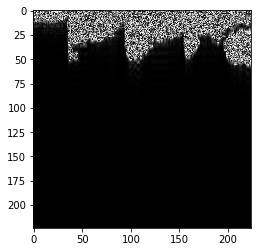

In [177]:
print(speech_y_true[np.argmax(-errors_mos)], speech_y_pred[np.argmax(-errors_mos)])
plt.imshow(speech_X_test[np.argmax(-errors_mos)])
plt.show()

[ 0.] [ 0.98146605]


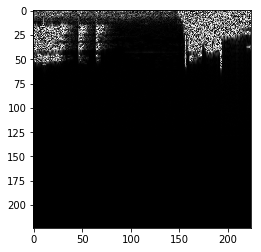

In [176]:
print(speech_y_true[np.argmax(errors_mos)], speech_y_pred[np.argmax(errors_mos)])
plt.imshow(speech_X_test[np.argmax(errors_mos)])
plt.show()